In [1]:
%cd ..

c:\Users\admin\as.drug_indexer


In [3]:
import pandas as pd

df = pd.read_json(r'C:\Users\admin\medical_data_saved\drugs\crawled\raw.json')
print(df.head())

                 drug_name                                               link  \
0             Parafizz 650  https://songkhoe.medplus.vn/thuoc-parafizz-650...   
1                   Damrin  https://songkhoe.medplus.vn/thuoc-damrin-lieu-...   
2                   Gonesi                https://songkhoe.medplus.vn/gonesi/   
3              Bayer (Đức)  https://www.nhathuocankhang.com/thuoc-tiet-nie...   
4  Bổ thận dương Nhất Nhất  https://songkhoe.medplus.vn/thuoc-bo-than-duon...   

                                           chemicals  \
0  Paracetamol 650 mg\n(Tá dược gồm: acid citric ...   
1               Mỗi viên nang chứa:\nDiacerein 50 mg   
2                           Mỗi viên của Gonesi chứa   
3  Trong mỗi viên Progynova 2mg chứa:\nHoạt chất:...   
4                        Mỗi viên nén bao phim chứa:   

                                               usage  \
0  \nĐiều trị các triệu chứng đau nhức và sốt từ ...   
1  Thuốc Damrin là thuốc ETC được dùng để điều...   
2  Gones

In [4]:
df['chemicals_length'] = df['chemicals'].str.len()
print(df['chemicals_length'].describe())

long_chemicals = df[df['chemicals_length'] > 2000][['drug_name', 'chemicals', 'chemicals_length']]
long_chemicals.value_counts().sum()
print(long_chemicals)

count    45088.000000
mean        84.186812
std        127.032901
min          1.000000
25%         21.000000
50%         41.000000
75%        113.000000
max       6753.000000
Name: chemicals_length, dtype: float64
                           drug_name  \
3179                Epfepara codeine   
7008                   Meyersina 100   
10300        Cao ích mẫu Mediplantex   
10329  Terpin Codein - F Mediplantex   
15619         Diclofenac 50 Cửu Long   
17855                   Noclaud 50mg   
20073                         Ukapin   
21173                  Degodas 2,5mg   
26796                  Carmotop 50mg   
29085  Paracetamol 650mg Mediplantex   
29558                    Roscef 10mg   
31051                    Zaclid 20mg   
31797                 RICHSTATIN 5mg   
32953                          ADMED   
32956                       Penveril   
33587                  Degodas 2,5mg   
33770        Cao ích mẫu Mediplantex   
34107           Medikids Mediplantex   
35279                    

In [5]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
45083     True
45084    False
45085    False
45086     True
45087    False
Length: 45088, dtype: bool

In [6]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38471 entries, 0 to 45087
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   drug_name         38471 non-null  object
 1   link              38471 non-null  object
 2   chemicals         38471 non-null  object
 3   usage             38471 non-null  object
 4   side_effects      38471 non-null  object
 5   chemicals_length  38471 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


In [7]:
sub_df = df[['drug_name', 'chemicals']].copy()
print(sub_df.head())

                 drug_name                                          chemicals
0             Parafizz 650  Paracetamol 650 mg\n(Tá dược gồm: acid citric ...
1                   Damrin               Mỗi viên nang chứa:\nDiacerein 50 mg
2                   Gonesi                           Mỗi viên của Gonesi chứa
3              Bayer (Đức)  Trong mỗi viên Progynova 2mg chứa:\nHoạt chất:...
4  Bổ thận dương Nhất Nhất                        Mỗi viên nén bao phim chứa:


In [ ]:
import re
import pandas as pd
import unicodedata
from plasma.search_engines.regex_splitter import RegexTokenizer

VIETNAMESE_STOP_PHRASES = [
    "mỗi viên nang chứa", "mỗi viên nén chứa", "mỗi viên bao phim chứa",
    "trong mỗi viên", "mỗi lọ chứa", "mỗi ống chứa", "thành phần chính",
    "thành phần gồm", "hoạt chất chính", "thành phần:", "mỗi viên nang cứng bao gồm",
    "1 thành phần thuốc có", "mỗi gói hỗn dịch uống chứa", "cho 1 lọ",
    "hàm lượng", "bao gồm", "gồm", "hoạt chất", "bao phim", "thành phần",
    "thuốc", "có", "viên", "chứa", "mỗi", "của", "dược chất", "là", "nang",
    "dưới dạng", "túi", "một", "các", "ống", "chính", "nén", "lọ", "cứng",
    "bao", "được", "cấu tạo", "1 Thành phần", "trong", "với", "tương ứng",
    "một viên thuốc", "dài", "tá dược", "vừa đủ", "một số", "mỗi gói",
    "gam bột", "gói", "bột", "sau", "như", "kem", "gel", "dung dịch",
    "pellets", "granules", "cho", "công thức", "tương đương",
    "mỗi 1g chứa", "hoạt chất", "tá dược", "vừa đủ 1 viên", "mỗi túi thuốc"
]

def text_preprocessing(text: str) -> str:
    if not isinstance(text, str):
        return ""
    
    text = unicodedata.normalize('NFKC', text)
    
    header_removal_patterns = [
        r'^.*?mỗi\s+\d+g\s+chứa\s*[:]*\s*',
        r'^.*?hoạt chất\s*[:]*\s*',
        r'^.*?tá dược\s*[:]*\s*',
        r'^.*?mỗi viên.*?chứa\s*[:]*\s*',
        r'^.*?mỗi túi.*?chứa\s*[:]*\s*',
        r'^\s*-\s*',
    ]
    
    for pattern in header_removal_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    text = re.sub(r'\s{2,}', ' ', text)
    text = re.sub(r'\.{3,}', ' ', text)
    
    return text.strip()

def intelligent_remove_stop_headers(text: str) -> str:
    sorted_phrases = sorted(VIETNAMESE_STOP_PHRASES, key=len, reverse=True)
    
    header_patterns = [
        r'^.*?hoạt chất\s*[:]\s*',
        r'^.*?thành phần\s*[:]\s*',
        r'^.*?chứa\s*[:]\s*',
        r'^.*?mỗi.*?chứa\s*[:]*\s*',
        r'^\s*-\s*hoạt chất\s*[:]*\s*',
        r'^\s*-\s*tá dược\s*[:]*\s*',
        r'^\s*-\s*',
    ]
    
    for pattern in header_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    for phrase in sorted_phrases:
        pattern = re.compile(r'\b' + re.escape(phrase) + r'\b\s*[:\s]*', re.IGNORECASE)
        text = pattern.sub(' ', text)
    
    return re.sub(r'\s+', ' ', text).strip()

def clean_ingredient(ing: str) -> str:
    if not isinstance(ing, str):
        return ""
    
    ing = ing.strip()
    
    administrative_prefixes = [
        'dưới dạng', 'dạng', 'tương ứng', 'là', 'được gọi là', 'bao gồm',
        'trong đó', 'cụ thể là', 'hay còn gọi', 'còn được biết đến',
        'có hàm lượng', 'vừa đủ 1 viên', 'vừa đủ', 'mỗi túi thuốc'
    ]
    
    for prefix in administrative_prefixes:
        pattern = rf'^{re.escape(prefix)}\s+'
        ing = re.sub(pattern, '', ing, flags=re.IGNORECASE)
    
    ing = re.sub(r'^[\s\,\.\(\)\[\]\'\":-]+', '', ing)
    ing = re.sub(r'[\s\,\.\(\)\[\]\'\":-]+$', '', ing)
    
    units_pattern = r'mg|g|mcg|μg|ml|mui|iu|%|mg/ml|g/ml|iu/ml|m\s*ui'
    ing = re.sub(rf'^\s*({units_pattern})\s+', '', ing, flags=re.IGNORECASE)
    
    stop_words = ['sau', 'như', 'một', 'số', 'các', 'với', 'trong', 'có', 'là', 'của']
    for word in stop_words:
        ing = re.sub(rf'^{re.escape(word)}\s*$', '', ing, flags=re.IGNORECASE)
    
    ing = re.sub(r'\s+', ' ', ing)
    return ing.strip(' :–,.')

def is_valid_ingredient(ing: str) -> bool:
    if not isinstance(ing, str) or not ing.strip():
        return False
    
    ing = ing.strip()
    
    if len(ing) < 2 or len(ing) > 80:
        return False

    pure_dose_patterns = [
        r'^\d+(?:[,\.]\d+)?\s*(?:mg|g|mcg|μg|ml|mui|iu|%|mg/ml|g/ml|iu/ml)$', 
        r'^w\.\s*\d+(?:[,\.]\d+)?\s*(?:mg|g)$', 
    ]
    
    for pattern in pure_dose_patterns:
        if re.search(pattern, ing, re.IGNORECASE):
            return False
    
    vietnamese_admin_exact = [
        'vừa đủ 1 viên', 'vừa đủ', 'mỗi túi thuốc', 'có hàm lượng', 
        'hàm lượng', 'một viên', 'mỗi viên', 'túi thuốc', 'viên thuốc'
    ]
    
    if ing.lower() in vietnamese_admin_exact:
        return False

    mixed_admin_patterns = [
        r'\b(?:có|với|trong|mỗi|vừa đủ|hàm lượng)\b.*\b(?:viên|túi|thuốc|mg|g)\b',
        r'^\d+(?:[,\.]\d+)?\s*g$', 
        r'^w\.\s*\d',             
    ]
    
    for pattern in mixed_admin_patterns:
        if re.search(pattern, ing, re.IGNORECASE):
            return False

    chemical_prefixes = ['a-', 'α-', 'β-', 'γ-', 'δ-', 'l-', 'd-', 'n-', 'o-', 'p-', 'm-']
    if any(ing.lower().startswith(prefix) for prefix in chemical_prefixes):
        return True
    
    pharmaceutical_patterns = [
        r'[a-zA-Z]+acid$', r'[a-zA-Z]+ine$', r'[a-zA-Z]+ate$', r'[a-zA-Z]+ide$',
        r'[a-zA-Z]+ose$', r'[a-zA-Z]+ol$', r'[a-zA-Z]+yl$', r'[a-zA-Z]+mycin$',
        r'[a-zA-Z]+cillin$', r'[a-zA-Z]+statin$', r'[a-zA-Z]+prazole$'
    ]
    
    for pattern in pharmaceutical_patterns:
        if re.search(pattern, ing.lower()):
            return True
    
    vietnamese_medicine_patterns = [
        r'bột\s+vỏ\s+sò', r'vitamin\s+[a-z0-9]+', r'cao\s+khô', r'tinh\s+dầu',
        r'lactose', r'cellulose', r'stearate'
    ]
    for pattern in vietnamese_medicine_patterns:
        if re.search(pattern, ing.lower()):
            return True
    
    strict_reject = [
        r'^(sau|như|một|số|các|kem|gel|trong|với|có|là|mỗi|chứa|của|được|bao|viên|nang|hoạt|chất|tá|dược|va|và)$',
        r'^(pellets|granules|dưới|dạng|túi|thuốc|hàm|lượng)$',
    ]
    
    for pattern in strict_reject:
        if re.search(pattern, ing, re.IGNORECASE):
            return False
    
    if not re.search(r'[a-zA-ZÀ-ỹ]', ing):
        return False
    
    alpha_count = len(re.findall(r'[a-zA-ZÀ-ỹ0-9\-]', ing))
    if alpha_count / len(ing) < 0.4:
        return False
    
    return True

def extract_chemicals(text, drug_name=None, tokenizer=None):
    if pd.isna(text) or not isinstance(text, str) or not text.strip():
        return [{'ingredient': '', 'dose': None}]
    
    original_text = text
    text = text_preprocessing(text)
    
    if isinstance(drug_name, str) and drug_name.strip():
        drug_pattern = r'\b' + re.escape(drug_name.lower()) + r'\b'
        text = re.sub(drug_pattern, '', text, flags=re.IGNORECASE)
    
    results = []
    units = r'mg|g|mcg|μg|ml|mui|iu|%|mg/ml|g/ml|iu/ml|m\s*ui|million\s*ui|k\s*ui'

    main_dose_paren_pattern = rf'([a-zA-ZÀ-ỹ0-9\s\-,\.]+?)\s+(\d+(?:[,\.]\d+)?\s*(?:{units}))\s*\(([^)]+)\)'
    main_dose_paren_matches = re.findall(main_dose_paren_pattern, text)
    
    if main_dose_paren_matches:
        for main_chem, dose, paren_content in main_dose_paren_matches:
            main_clean = clean_ingredient(main_chem.strip())
            dose_clean = dose.replace(',', '.').replace(' ', '') if dose else None
            
            if is_valid_ingredient(main_clean):
                results.append({'ingredient': main_clean, 'dose': dose_clean})
            
            paren_clean = clean_ingredient(paren_content.strip())
            if is_valid_ingredient(paren_clean) and paren_clean.lower() != main_clean.lower():
                results.append({'ingredient': paren_clean, 'dose': None})
        
        if results:
            return results

    chem_paren_dose_pattern = rf'([a-zA-ZÀ-ỹ0-9\s\-,\.]+)\s*\(([^)]+)\)\s*(\d+(?:[,\.]\d+)?\s*(?:{units}))'
    chem_paren_dose_matches = re.findall(chem_paren_dose_pattern, text)
    
    if chem_paren_dose_matches:
        for main_chem, paren_content, dose in chem_paren_dose_matches:
            main_clean = clean_ingredient(main_chem.strip())
            dose_clean = dose.replace(',', '.').replace(' ', '')
            
            if is_valid_ingredient(main_clean):
                results.append({'ingredient': main_clean, 'dose': dose_clean})
            
            paren_clean = clean_ingredient(paren_content.strip())
            if is_valid_ingredient(paren_clean) and paren_clean.lower() != main_clean.lower():
                results.append({'ingredient': paren_clean, 'dose': None})
        
        if results:
            return results

    text = re.sub(r'\b(va|và)\b', ',', text, flags=re.IGNORECASE)
    
    text_no_parens = re.sub(r'\([^)]*\)', '', text)
    comma_items = []
    parts = text_no_parens.split(',')
    
    i = 0
    while i < len(parts):
        current_part = parts[i].strip()
        
        if (i < len(parts) - 1 and 
            re.match(r'^\d+$', current_part) and 
            len(parts[i + 1].strip()) > 0):
            combined = current_part + ',' + parts[i + 1].strip()
            comma_items.append(combined)
            i += 2
        else:
            comma_items.append(current_part)
            i += 1
    
    if len(comma_items) > 1:
        for item in comma_items:
            item = item.strip()
            if not item:
                continue

            dose_match = re.search(rf'(\d+(?:[,\.]\d+)?\s*(?:{units}))', item)
            if dose_match:
                dose = dose_match.group(1).replace(',', '.').replace(' ', '')
                ingredient_part = re.sub(rf'\d+(?:[,\.]\d+)?\s*(?:{units})', '', item).strip()
                ingredient_clean = clean_ingredient(ingredient_part)
                if is_valid_ingredient(ingredient_clean):
                    results.append({'ingredient': ingredient_clean, 'dose': dose})
            else:
                item_clean = clean_ingredient(item)
                if is_valid_ingredient(item_clean):
                    results.append({'ingredient': item_clean, 'dose': None})
        
        if results:
            return results

    single_chem_dose_pattern = rf'([a-zA-ZÀ-ỹ0-9\-,\.\s]+?)\s+(\d+(?:[,\.]\d+)?\s*(?:{units}))'
    single_matches = re.findall(single_chem_dose_pattern, text_no_parens)
    
    if single_matches:
        for ing, dose in single_matches:
            ing_clean = clean_ingredient(ing.strip())
            dose_clean = dose.replace(',', '.').replace(' ', '')
            if is_valid_ingredient(ing_clean):
                results.append({'ingredient': ing_clean, 'dose': dose_clean})
        return results
    
    text_cleaned = intelligent_remove_stop_headers(text_no_parens)
    
    if text_cleaned and len(text_cleaned.strip()) >= 2:
        direct_clean = clean_ingredient(text_cleaned)
        if is_valid_ingredient(direct_clean):
            results.append({'ingredient': direct_clean, 'dose': None})
        else:
            fallback_pattern = rf'([a-zA-ZÀ-ỹ0-9\-,\.\s]{2,})'
            fallback_matches = re.findall(fallback_pattern, text_cleaned)
            
            for potential in fallback_matches:
                cleaned_potential = clean_ingredient(potential)
                if is_valid_ingredient(cleaned_potential):
                    results.append({'ingredient': cleaned_potential, 'dose': None})
    
    if results:
        seen = set()
        unique_results = []
        for item in results:
            ingredient_key = item['ingredient'].lower()
            if ingredient_key not in seen and ingredient_key:
                seen.add(ingredient_key)
                unique_results.append(item)
        return unique_results
    
    return [{'ingredient': '', 'dose': None}]

tokenizer = RegexTokenizer(r'[A-Z][a-z]+(?:\s[A-Z][a-z]+)*\s\d+(?:mg|ml|mcg|g|%)')

sub_df = df[['drug_name', 'chemicals']].copy()
sub_df['parsed_chemicals'] = sub_df.apply(
    lambda row: extract_chemicals(row['chemicals'], row['drug_name'], tokenizer),
    axis=1
)

sub_df.head(50)

,drug_name,chemicals,parsed_chemicals
0,Parafizz 650,Paracetamol 650 mg\n(Tá dược gồm: acid citric ...,"[{'ingredient': 'Paracetamol', 'dose': '650mg'}]"
1,Damrin,Mỗi viên nang chứa:\nDiacerein 50 mg,"[{'ingredient': 'Diacerein', 'dose': '50mg'}]"
2,Gonesi,Mỗi viên của Gonesi chứa,"[{'ingredient': '', 'dose': None}]"
3,Bayer (Đức),Trong mỗi viên Progynova 2mg chứa:\nHoạt chất:...,[{'ingredient': 'Hoạt chất: Estradiol valerate...
4,Bổ thận dương Nhất Nhất,Mỗi viên nén bao phim chứa:,"[{'ingredient': '', 'dose': None}]"
5,Propara 450mg/3ml,\nThuốc Propara 450mg/3ml được sử dụng để giả...,[{'ingredient': 'Thuốc được sử dụng để giảm đa...
6,Acepron,Paracetamol,"[{'ingredient': 'Paracetamol', 'dose': None}]"
7,Newtiam,Mỗi lọ chứa:,"[{'ingredient': '', 'dose': None}]"
8,Piroxicam Stada 20mg,Piroxicam 20mg,"[{'ingredient': 'Piroxicam', 'dose': '20mg'}]"
9,Fuspiro,1 Thành phần\nThành phần: Trong mỗi viên thuốc...,"[{'ingredient': 'Spironolacton', 'dose': '50mg..."


In [18]:
sub_df['parsed_chemicals'] = sub_df['parsed_chemicals'].apply(
    lambda x: None if isinstance(x, list) and len(x) == 0 else x
)

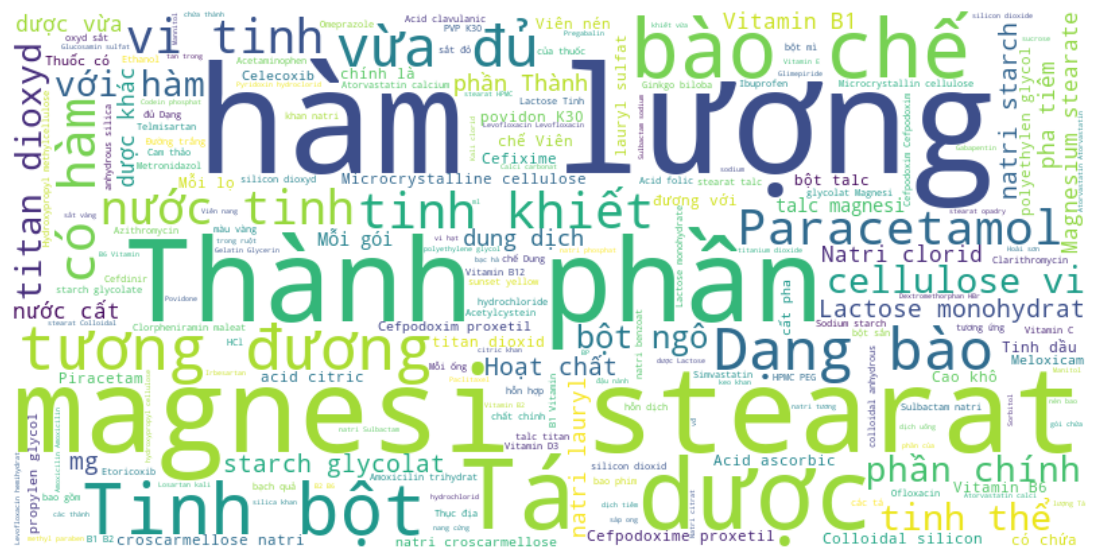

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract all ingredient names from parsed_chemicals
all_ingredients = []
for parsed_list in sub_df['parsed_chemicals']:
	if isinstance(parsed_list, list):
		for chem in parsed_list:
			if isinstance(chem, dict) and chem.get('ingredient'):
				all_ingredients.append(chem['ingredient'])

# Join all ingredient names into a single string
ingredients_text = ' '.join(all_ingredients)

# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ingredients_text)

# Display the generated image:
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
import pandas as pd

df_pics = pd.DataFrame({
    'path': [
        r"C:\Users\admin\Documents\data\.data\20231213145107_001.pdf.0000.png",
        r"C:\Users\admin\Documents\data\.data\20140119215734_001.pdf.0000.png",
        r"C:\Users\admin\Documents\data\.data\a8e7c9eca5b61ee847a7.jpg.0000.png"
    ],
    'ocr_text': [
        [
            "Ibandronic Acid (Jointmeno) 150mg – Viên uống, 1 viên/tháng, dùng buổi sáng, uống với ~150ml nước, không ăn/uống thêm trong 1h",
            "NextG Cal 500mg – Viên uống, 2 viên/trưa, 30 ngày, tổng liều 60 viên"
        ],
        [
            "Levofloxacin (LEVODHG 500) 500mg – Viên, tổng 14 viên (2 viên/ngày, sáng-tối, 7 ngày)",
            "Diosmin + hesperidin (Venokern 500mg) 450mg + 50mg – Viên, 60 viên (6 viên/ngày đầu chia 3 lần, sau uống 4 viên/ngày chia 2 lần)"
        ],
        [
            "Bình vị nam - Việt Nam – 300 viên (uống 10 viên/ngày, 5 sáng, 5 tối)",
            "Modom'S (Domperidone 10mg) – 60 viên (2 viên/ngày, sáng-tối, 1 viên/lần)",
            "Hacumin (Nano Curcumin, Royal Jelly) – 60 viên (2 viên/ngày, sáng-tối)",
            "Somastop (Sucralfat) – 60 viên (2 viên/ngày, sáng-tối)",
            "Repratt (Pantoprazol 40mg) – 60 viên (2 viên/ngày, sáng-tối)"
        ]
    ]
})

df_pics.head()

,path,ocr_text
0,C:\Users\admin\Documents\data\.data\2023121314...,[Ibandronic Acid (Jointmeno) 150mg – Viên uống...
1,C:\Users\admin\Documents\data\.data\2014011921...,"[Levofloxacin (LEVODHG 500) 500mg – Viên, tổng..."
2,C:\Users\admin\Documents\data\.data\a8e7c9eca5...,[Bình vị nam - Việt Nam – 300 viên (uống 10 vi...


In [21]:
import networkx as nx
import pandas as pd

def create_drug_graph(sub_df):
    """Create NetworkX graph from pharmaceutical database"""
    G = nx.DiGraph()
    
    for idx, row in sub_df.iterrows():
        drug_name = str(row['drug_name']).strip() if pd.notna(row['drug_name']) else ''
        if len(drug_name) > 2:
            G.add_node(drug_name, 
                      db_index=idx,
                      chemicals=row['chemicals'],
                      parsed_chemicals=row['parsed_chemicals'])
    
    return G

drug_graph = create_drug_graph(sub_df)

print(drug_graph)

DiGraph with 33331 nodes and 0 edges


In [32]:
import re
from plasma.search_engines.token_matcher import TokenMatcher

def drug_extraction(ocr_text_list):
    """Enhanced extraction prioritizing primary English drug names"""
    all_drugs = []
    
    for text in ocr_text_list:
        if not isinstance(text, str):
            continue
        
        clean_text = text.split('–')[0].strip()
        
        vietnamese_pattern = r'^([A-Z][a-zA-ZÀ-ỹ\s]+?)\s*-\s*Việt Nam'
        vietnamese_match = re.match(vietnamese_pattern, clean_text, re.IGNORECASE)
        if vietnamese_match:
            vietnamese_drug = vietnamese_match.group(1).strip()
            all_drugs.append(vietnamese_drug)
            continue

        primary_english_pattern = r'^([A-Z][a-zA-Z\'\s]+?)(?:\s*\(|\s+\d+(?:[.,]\d+)?\s*(?:mg|ml|g|%|iu|mcg))'
        primary_match = re.match(primary_english_pattern, clean_text)
        
        if primary_match:
            main_drug = primary_match.group(1).strip()
            if (len(main_drug) > 2 and 
                not main_drug.lower().endswith('nam') and
                main_drug[0].isupper()):
                all_drugs.append(main_drug)
        
        paren_pattern = r'\(([^)]+)\)'
        paren_matches = re.findall(paren_pattern, clean_text)
        
        for paren_content in paren_matches:
            if ',' in paren_content:
                items = [item.strip() for item in paren_content.split(',')]
                for item in items:
                    cleaned_item = re.sub(r'\d+(?:[.,]\d+)?\s*(?:mg|ml|g|%|iu|mcg)', '', item).strip()
                    if (len(cleaned_item) > 2 and 
                        cleaned_item[0].isupper() and
                        not re.match(r'^\d', cleaned_item)):
                        all_drugs.append(cleaned_item)
            else:
                # Single item in parentheses
                cleaned_paren = re.sub(r'\d+(?:[.,]\d+)?\s*(?:mg|ml|g|%|iu|mcg)', '', paren_content).strip()
                if (len(cleaned_paren) > 2 and 
                    cleaned_paren[0].isupper() and
                    not re.match(r'^\d', cleaned_paren)):
                    all_drugs.append(cleaned_paren)

        compound_pattern = r'([A-Z][a-zA-Z]+(?:\s*\+\s*[a-zA-Z]+)+)'
        compound_matches = re.findall(compound_pattern, clean_text)
        for compound in compound_matches:
            all_drugs.append(compound.strip())
    
    cleaned_drugs = []
    for drug in all_drugs:
        drug = re.sub(r'\d+(?:[.,]\d+)?\s*(?:mg|ml|g|%|iu|mcg)', '', drug)
        drug = re.sub(r'\s*-?\s*Việt Nam', '', drug, flags=re.IGNORECASE)
        drug = drug.strip(' .,()–-')
        
        if (len(drug) > 2 and 
            not re.match(r'^\d+$', drug) and
            drug.lower() not in ['viên', 'uống', 'ngày', 'tổng', 'chia', 'lần', 'với', 'nước', 'vietnam', 'nam']):
            cleaned_drugs.append(drug)
    
    return list(set(cleaned_drugs))

# Apply fixed extraction
df_pics['extracted_drug_names'] = df_pics['ocr_text'].apply(drug_extraction)

# Flatten results
all_extracted_drugs = []
for idx, row in df_pics.iterrows():
    for drug in row['extracted_drug_names']:
        all_extracted_drugs.append({
            'image_path': row['path'],
            'extracted_drug': drug
        })

df_all_drugs = pd.DataFrame(all_extracted_drugs)
token_matcher = TokenMatcher(graph = drug_graph, threshold=0.6)

# Match with database
unique_drugs = df_all_drugs['extracted_drug'].unique().tolist()
matches = token_matcher.run(unique_drugs)

enhanced_matching_results = []

for drug, match_scores in zip(unique_drugs, matches):
    if not match_scores.empty:
        best_match = match_scores.idxmax()
        best_score = match_scores.max()
        
        enhanced_matching_results.append({
            'extracted_drug': drug,
            'matched_drug': best_match,
            'similarity_score': best_score,
            'chemicals': drug_graph.nodes[best_match]['parsed_chemicals'],
            'db_index': drug_graph.nodes[best_match]['db_index']
        })
    else:
        enhanced_matching_results.append({
            'extracted_drug': drug,
            'matched_drug': None,
            'similarity_score': 0.0,
            'chemicals': None,
            'db_index': None
        })

df_matches = pd.DataFrame(enhanced_matching_results)

print(df_matches)

          extracted_drug     matched_drug  similarity_score  \
0              Jointmeno       Jointcerin          0.736842   
1        Ibandronic Acid   Nalidixic Acid          0.620690   
2              NextG Cal   PM \nNextG Cal          0.818182   
3           Levofloxacin     Levofloxacin          1.000000   
4   Diosmin + hesperidin       Domperidon          0.600000   
5            LEVODHG 500      LEVODHG 250          0.909091   
6               Venokern         Venokern          1.000000   
7          Nano Curcumin        Trancumin          0.636364   
8                Modom'S     Modom'S 10mg          0.736842   
9                Repratt          Deplatt          0.714286   
10              Somastop          Sotstop          0.800000   
11             Sucralfat       Sucralfate          0.947368   
12           Pantoprazol      Pantoprazol          1.000000   
13           Bình vị nam      Cốm Bình vị          0.636364   
14               Hacumin        Usacumine          0.75